<a href="https://colab.research.google.com/github/PhD-Gabriel-Caballero/ESA-summer-school-2023-Croatia/blob/main/S2_based_LAI_retrieval_using_parametric_indices_in_Google_Earth_Engine_(GEE).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S2-based LAI retrieval using parametric indices in Google Earth Engine (GEE)

---

This Jupyter notebook contains all the necessary information for retrieving the Leaf Area Index (LAI) in the Google Earth (GEE) cloud computing platform. This material has been created exclusively for the 2023 European Space Agency (ESA) summer school.

---



**LAI definition**

Leaf area index (LAI), one half the total green leaf area per unit horizontal ground surface, is an important structural property of vegetation. Because leaf surfaces are the primary border of energy and mass exchange, important processes such as canopy interception, evapotranspiration, and gross photosynthesis are directly proportional to LAI
[LAI ScienceDirect](https://www.sciencedirect.com/topics/earth-and-planetary-sciences/leaf-area-index#:~:text=Leaf%20area%20index%20is%20defined,of%20leaf%20area%20per%20hectare.).

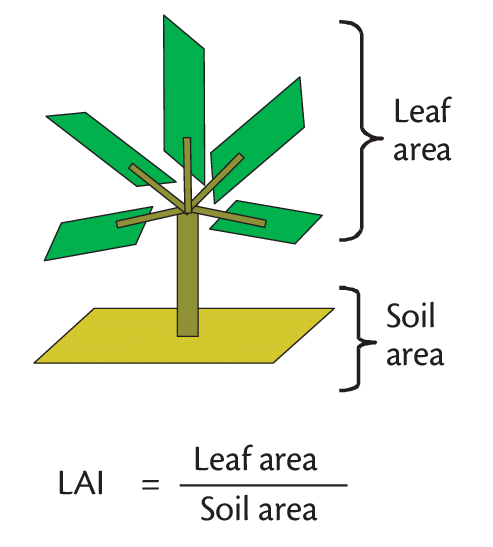

Barrett-Lennard, Edward & Malcolm, C.V. & Bathgate, A. (2003). Saltland Pastures in Australia: A practical guide.

---

Sentinel-2 directional reflectance as a function of LAI simulated in [ARTMO](https://artmotoolbox.com/) using the radiative transfer coupled model 4SAIL+PROSPECT-PRO.
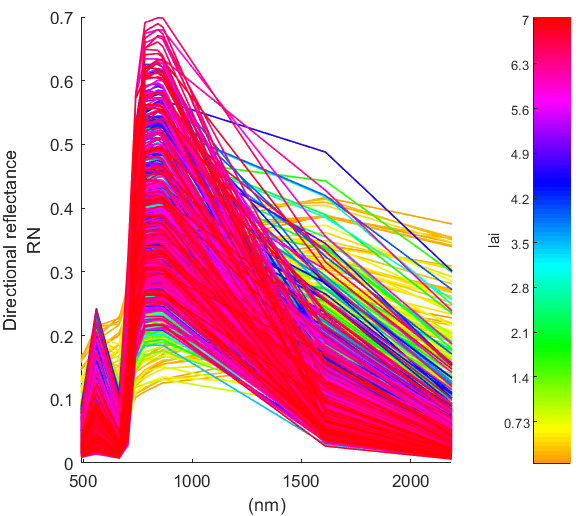


Theoretical background
---
The enhanced vegetation index (EVI) is a vegetation index that has been optimized to improve vegetation monitoring. It achieves this by enhancing the vegetation signal with better sensitivity in regions with high biomass, decoupling the canopy background signal and reducing atmospheric influences.

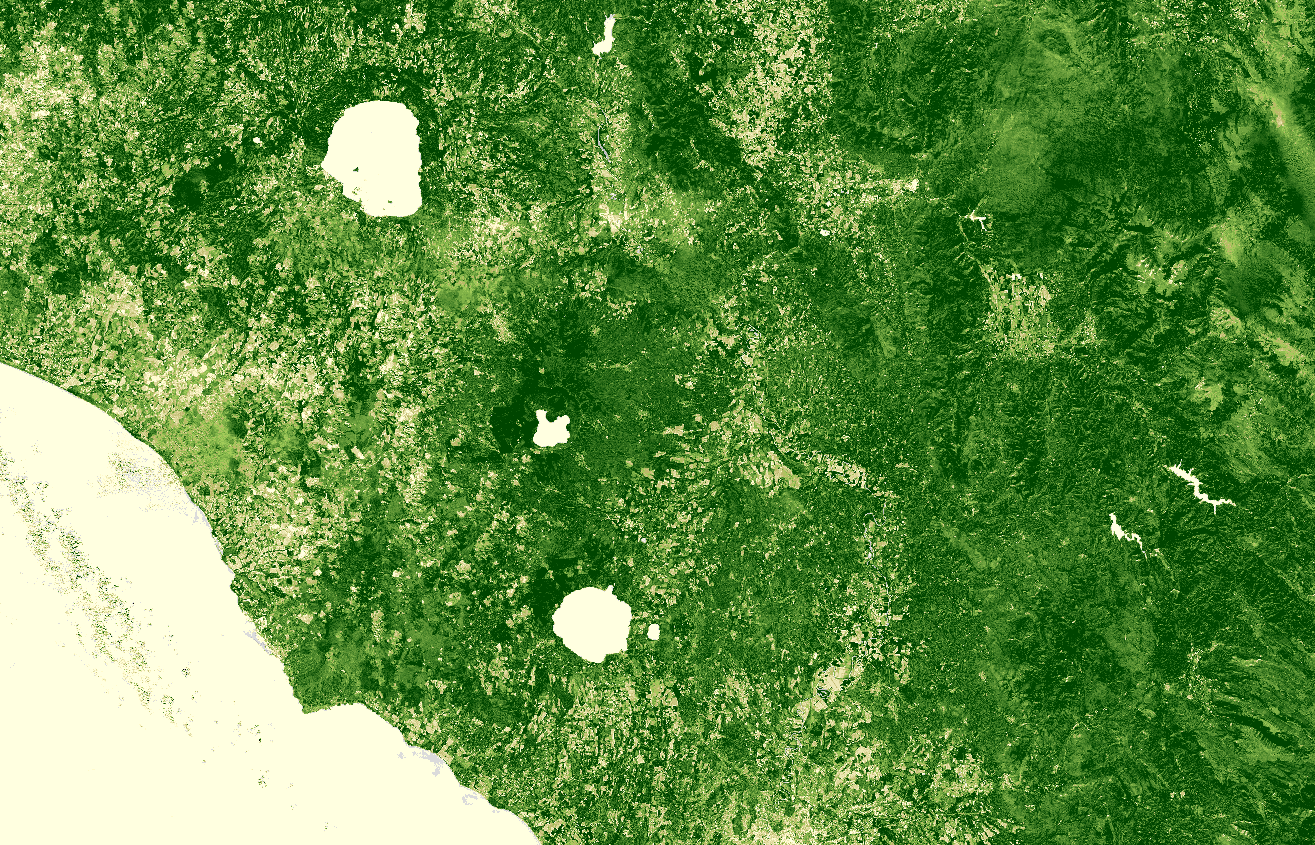

EVI, Italy. Acquired on 08.10.2017, processed by Sentinel Hub.
[EVI SentinelHub Playground](https://colab.research.google.com/drive/1a2Svp5wIYUNOHzQ-67jpw4KyJ6MZfnv2#scrollTo=53I7r3clfuV1&line=9&uniqifier=1)

A Huete, K Didan, T Miura, E.P Rodriguez, X Gao, L.G Ferreira, Overview of the radiometric and biophysical performance of the MODIS vegetation indices,
Remote Sensing of Environment, Volume 83, Issues 1–2,
2002, Pages 195-213, ISSN 0034-4257, https://doi.org/10.1016/S0034-4257(02)00096-2.


Install all the necessary Python packages to run this application code.

In [ ]:
!pip install geemap
!pip install earthengine-api
!pip install ipygee
!pip install PyCRS

Import Python packages

In [2]:
# Import earth engine python api and geemap
import geemap, ee, os, sys, pycrs, datetime
import geemap.colormaps as cm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Clone the GitHub repository

In [ ]:
!rm -r ESA-summer-school-2023-Croatia # delete the complete repository folder
!git clone https://github.com/PhD-Gabriel-Caballero/ESA-summer-school-2023-Croatia # clone repository folder
sys.path.insert(0,'/content/ESA-summer-school-2023-Croatia')

To use the Earth Engine API on the GEE cloud platform, import ee and geemap, and then log in to authenticate.

In [ ]:
# Authenticate the earthengine with credentials
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

Define and visualize the study area

In [5]:
# Set map display properties.
Map = geemap.Map(toolbar_ctrl=True, layer_ctrl=True)
Map.default_style = {'cursor': 'crosshair'}
Map.add_basemap('SATELLITE')

# Center the map in the desired country
country = 'Argentina'
country_bounds = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017").filterMetadata('country_na', 'equals', country);
Map.centerObject(country_bounds,6)
Map

Map(center=[-34.687845828472675, -64.74963675588427], controls=(WidgetControl(options=['position', 'transparen…

Show the Region Of Interest (ROI) in the interactive map

In [6]:
# Please provide here the information on the experimental station and the boundaries of your crop essay.
wheat_roi = geemap.shp_to_ee('/content/ESA-summer-school-2023-Croatia/Vectors/Wheat trial sketch 2020/wheat trial sketch 2020.shp')
EEHA_roi = geemap.shp_to_ee('/content/ESA-summer-school-2023-Croatia/Vectors/EEHA boundaries/INTA EEHA subdivision 2020.shp')

Map.addLayer(wheat_roi, {},'Wheat roi 2020',True)
Map.addLayer(EEHA_roi, {},'Study area',True, opacity = 0.5)

In [7]:
feature = Map.draw_last_feature
analized_roi = feature.geometry(proj="EPSG:4326")

Please provide the definitions of the functions

Sentinel-2 spectral band configuration

---
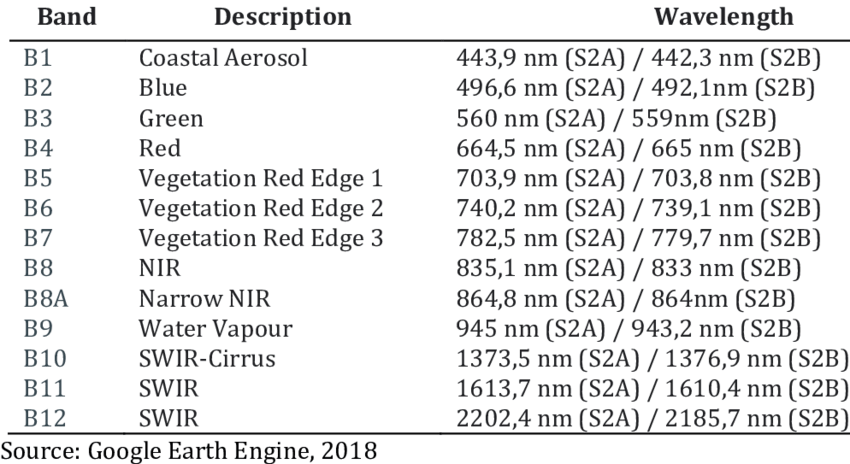




In [8]:
# Function to calculate and add a parametric index band (EVI)

# Original definition of EVI index:
#EVI = 2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))

# Sentinel-1 bands:
#NIR = B8 (842nm)
#RED = B4 (665 nm)
#BLUE = B2 (490 nm)

# ARTMO-based EVI formulation for S2 spectral configuration:
# EVI [2.5.*((B2*-B3*)./(B2*+(6.*B3*)-7.5.*(B1*)+1))]

# Bands:
# B1*=560 nm
# B2*=740 nm
# B3*=783 nm

# (*) indicates the ordinal number of the spectral bands used in ARTMO.

def addEVI(image):
    # Compute the EVI parametric index.
    EVI = image.expression(
        '2.5 * ((band2 - band3) / (band2 + 6 * band3 - 7.5 * band1 + 1))', {
            'band1': image.select('B3'),
            'band2': image.select('B6'),
            'band3': image.select('B7')
        }).rename("EVI")

    image = image.addBands(EVI)

    return(image)

LAI linear regression in ARTMO based on EVI spectral index and wheat in situ data

NRME = 13.7537 %; R2=0.8525

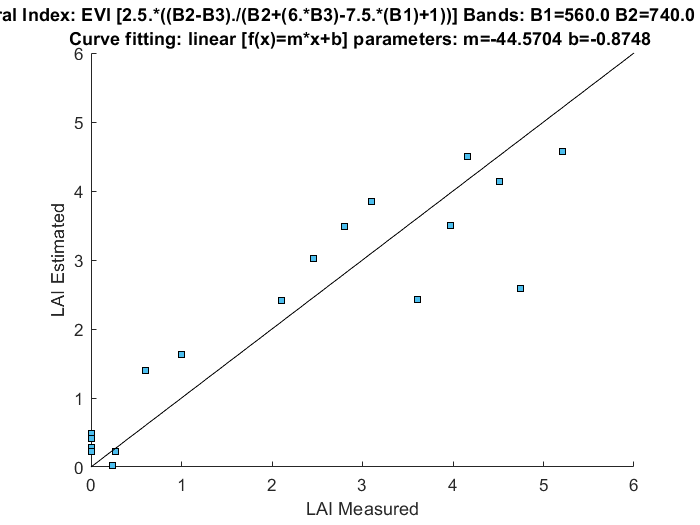

In [9]:
# Function to calculate and add a parametric index band (LAI)

# The curve fitting was obtained through ARTMO: linear [f(x)=m*x+b] parameters: m=33.5111 b=-0.8891
# LAI = -44.5704*EVI - 0.8748

def addLAI(image):
    LAI = image.expression(
        '(-44.5704*EVI - 0.8748)', {
            'EVI': image.select('EVI')
        }).rename("LAI")
    image = image.addBands(LAI)

    return(image)

In [10]:
# Clipping image collection by geometry
def clipcol(image):
    clipimage = image.clip(EEHA_roi)
    return clipimage

In [11]:
# Masking function for water and cloud

def maskS2cloud_and_water(image):
  not_water = image.select('SCL').neq(6);
  not_cloud_low = image.select('SCL').neq(7);
  not_cloud_medium = image.select('SCL').neq(8);
  not_cloud_high = image.select('SCL').neq(9);
  not_cirrus = image.select('SCL').neq(10);

  # Bits 10 and 11 are clouds and cirrus, respectively.
  qa = image.select('QA60');
  cloudBitMask = 1 << 10;
  cirrusBitMask = 1 << 11;

  # Both flags should be set to zero, indicating clear conditions.
  mask = (qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0)).And(not_water).And(not_cloud_low)
          .And(not_cloud_medium).And(not_cloud_high).And(not_cirrus))
  return image.updateMask(mask).divide(10000).copyProperties(qa).set('system:time_start', qa.get('system:time_start'))


---

Bitmask for QA60

Bits 0-9: Unused

Bit 10: Opaque clouds
  0: No opaque clouds
  1: Opaque clouds present
  
Bit 11: Cirrus clouds
  0: No cirrus clouds
  1: Cirrus clouds present

---

SLC Scene Classification Map band
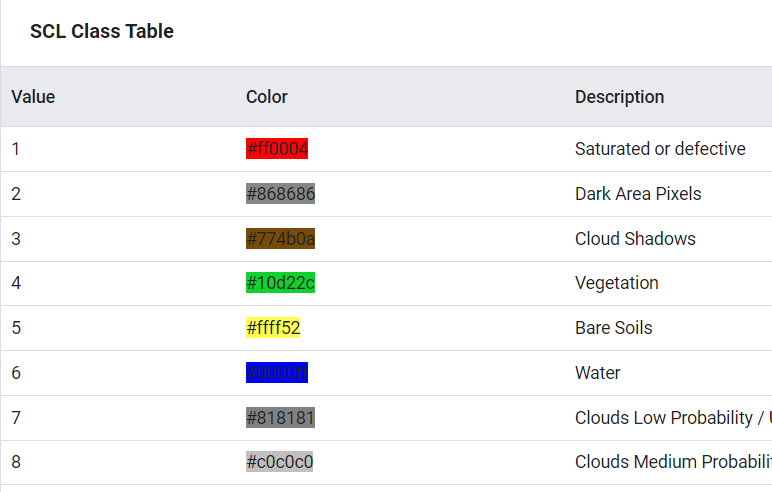
---

To get a complete understanding of the Q60 cloud mask and the SCL Scene Classification Map bands, kindly refer to the link provided below:

[Q60 Cloud mask](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR#bands)

---

If you're looking for a more intricate method for obtaining cloud and shadow-free images in GEE, check out the tutorial available through the following link:

[Sentinel-2 Cloud Masking with s2cloudless](https://developers.google.com/earth-engine/tutorials/community/sentinel-2-s2cloudless)

This tutorial is an introduction to masking clouds and cloud shadows in Sentinel-2 (S2) surface reflectance (SR) data using Earth Engine. Clouds are identified from the S2 cloud probability dataset (s2cloudless) and shadows are defined by cloud projection intersection with low-reflectance near-infrared (NIR) pixels.

---


Dates of interest and acquisitions configuration parameters

In [58]:
# Configuration Parameters
start_date = '2023-07-01'
end_date = '2023-08-02'
S2_CPP = 30 # CLOUDY_PIXEL_PERCENTAGE
roi = wheat_roi.geometry() # Select the current region of interest

Create the initial image collection with the spectral bands

In [59]:
# Retrieving Sentinel 2 imagery
print('SENTINEL-2 time series being retrieved')
S2collection_raw = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
                   .filterBounds(roi)\
                   .filterDate(start_date,end_date)\
                   .filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than', S2_CPP)\
                   .map(maskS2cloud_and_water)\
                   .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','B8','B8A','B11','B12'])\

# Apply water masking functions to the image collection
#S2collection_aux = S2collection_raw.map(addEVI).map(clipcol);
S2collection_ini = S2collection_raw.map(addEVI).map(clipcol).select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','B8','EVI']);


SENTINEL-2 time series being retrieved


Sentinel 2 date label extraction

In [60]:
# Creating labels - Multitemporal plotting
labels_S2 = S2collection_ini.aggregate_array("system:index").getInfo()

# Dates S2
Dates_S2 = []
for i in labels_S2:
    Dates_S2.append(datetime.datetime.strptime(i.split('_')[0].split('T')[0], '%Y%m%d').date())
Dates_S2.sort()

#datetime.datetime.strptime(date, "%Y-%m-%d")
#https://stackoverflow.com/questions/19480028/attributeerror-datetime-module-has-no-attribute-strptime

Generate a collection of retrieved images by using parametric indices

In [61]:
# Add the LAI band to the image collection
S2_PI_LAI_collection = S2collection_ini.map(addLAI).select('LAI')

S2 image collection to a numpy array conversion

In [ ]:
S2_PI_LAI_image = S2_PI_LAI_collection.toBands().unmask(0);
S2_PI_LAI_image_nparray = geemap.ee_to_numpy(ee_object = S2_PI_LAI_image.toArray(), region=analized_roi, default_value=None)

print('S2 ROI Dimension')
print(S2_PI_LAI_image_nparray.shape)

LAI mean calculation at ROI level

In [63]:
S2_PI_LAI_parcel_mean = S2_PI_LAI_image_nparray.mean(axis=1).mean(axis=0)
S2_PI_LAI_parcel_std = np.std(S2_PI_LAI_parcel_mean, axis=0)

In [67]:
Dates_S2

[datetime.date(2023, 7, 15)]

Plot S2-based LAI time series for the selected ROI

In [64]:
# Sentinel 2 LAI parametric index model time series plotting

axmaxloc = S2_PI_LAI_image_nparray.shape[2]/4;
axminloc = S2_PI_LAI_image_nparray.shape[2]/4;

plt.figure(figsize= (16,4))
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(axmaxloc))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(axminloc))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.plot(Dates_S2,S2_PI_LAI_parcel_mean,linestyle="--",marker="o",markerfacecolor='c',markeredgecolor='k',markersize=6,lw=3,label='S2 LAI parametric model')
plt.fill_between(Dates_S2, S2_PI_LAI_parcel_mean-S2_PI_LAI_parcel_std,S2_PI_LAI_parcel_mean+S2_PI_LAI_parcel_std ,alpha=0.25,color='grey',label='S2 LAI (index) + 1*std')
plt.title('S2 Leaf Area Index',fontsize='20')
plt.legend()
plt.grid(1)
plt.ylabel('LAI [$m^2$ $m^{-2}$]',fontsize='14')
plt.grid(1)
plt.xticks(rotation=45, ha='right')
plt.show()

KeyboardInterrupt: ignored

Provide guidance on establishing colour schemes for plotting interactive maps

In [52]:
# Thematic colour palette definition for LAI mapping

palette = [
    'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
    '74A901', '66A000', '529400', '3E8601', '207401', '056201',
    '004C00', '023B01', '012E01', '011D01', '011301']

LAI_palette_1  = {"min":0.5, "max":3.5, 'palette':palette}

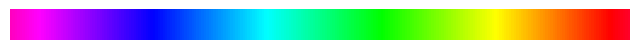

In [47]:
# Thematic colour palette definition for LAI mapping

palette = cm.get_palette('gist_rainbow_r', n_class=10)
LAI_palette_1 = {'min': 0, 'max': 3.5, 'palette': palette}
cm.plot_colormap('gist_rainbow_r', width=8.0, height=0.4, orientation='horizontal')

In [22]:
# Map display parameters definition (RGB S2 image)
vizParams = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 0.2,
}
#cm.list_colormaps()

Define an interactive map

In [72]:
Map_S2 = geemap.Map(toolbar_ctrl=True, layer_ctrl=True)
Map_S2.centerObject(roi, 14)
Map_S2.set_plot_options(add_marker_cluster=True)
Map_S2

Map(center=[-39.40069971185254, -62.639482218249064], controls=(WidgetControl(options=['position', 'transparen…

LAI map plotting

In [73]:
# S2-based leaf area index map display

image_number = 0 # select the ordinal number of the image you want to be displayed

# Converting the S2 image collection to an image list for RGB scene display
S2collection_list = S2collection_raw.toList(S2collection_raw.size());
S2image = ee.Image(S2collection_list.get(image_number));

# S2 RGB image display

Map_S2.addLayer(S2image,vizParams,'S2 RGB composite',True)

# Single variable display

S2_PI_LAI_image = S2_PI_LAI_collection.toBands()
Map_S2.addLayer(S2_PI_LAI_image.select(image_number),LAI_palette_1, 'S2 PI LAI')

# On-screen display of color bars

Map_S2.add_colorbar(LAI_palette_1, label="LAI ($m^2$ $m^{-2}$)", orientation="horizontal", layer_name="barato color bar")

# On-screen display of vector shapefile

Map_S2.addLayer(EEHA_roi, {},'Study area',True, opacity = 0.5)

In [50]:
# Variables collection display (mean, max or min).

Map_S2.addLayer(S2_PI_LAI_collection.mean(),LAI_palette_1, 'S2 LAI collection')

# On-screen display of variable time sliders

Map_S2.add_time_slider(S2_PI_LAI_collection ,LAI_palette_1, region=EEHA_roi,layer_name='S2 PI LAI time-series',labels=labels_S2, time_interval=1)